In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

100% 723M/723M [00:42<00:00, 18.6MB/s]
100% 723M/723M [00:42<00:00, 18.0MB/s]


In [3]:
!unzip jigsaw-unintended-bias-in-toxicity-classification.zip

Archive:  jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: all_data.csv            
  inflating: identity_individual_annotations.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_private_expanded.csv  
  inflating: test_public_expanded.csv  
  inflating: toxicity_individual_annotations.csv  
  inflating: train.csv               


In [4]:
import pandas as pd

# Load the dataset
train_csv_path = "train.csv"
data = pd.read_csv(train_csv_path)

# Display the column names to verify the correct names
print(data.columns)

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')


In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load and prepare data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_comments(texts):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=128,  # Increased max length for better context understanding
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

encoded_data = encode_comments(data['comment_text'].fillna(''))
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(data['target'].values)

# Prepare identity columns for fairness metrics
identity_columns = ['asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual',
                    'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish',
                    'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity',
                    'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness',
                    'transgender', 'white']
identities = data[identity_columns].values

# Train-test split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.1, random_state=42)
train_identities, validation_identities = train_test_split(identities, test_size=0.1, random_state=42)

# DataLoader setup
train_data = TensorDataset(train_inputs, train_masks, train_labels, torch.tensor(train_identities, dtype=torch.float32))
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, torch.tensor(validation_identities, dtype=torch.float32))
validation_dataloader = DataLoader(validation_data, sampler=SequentialSampler(validation_data), batch_size=32)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
from transformers import DistilBertForSequenceClassification, AdamW, get_scheduler
import torch

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Early stopping criteria
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Instantiate early stopping
early_stopping = EarlyStopping(patience=2, min_delta=0.01)

# Load DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Number of training epochs and scheduler
epochs = 2
num_training_steps = epochs * len(train_dataloader)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Training loop
best_valid_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_identities = batch
        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(outputs.logits.float(), b_labels.long())  # Cast logits to float and labels to long

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}, Loss: {loss.item()}")

    # Validation loss
    model.eval()
    eval_loss = 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_identities = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            loss = loss_fct(outputs.logits.float(), b_labels.long())  # Cast logits to float and labels to long

        eval_loss += loss.item()

    avg_valid_loss = eval_loss / len(validation_dataloader)
    print(f'Epoch {epoch}: Validation Loss: {avg_valid_loss}')

    # Check early stopping
    early_stopping(avg_valid_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Save the best model
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        model.save_pretrained('./model_save/')
        tokenizer.save_pretrained('./model_save/')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0, Step 0, Loss: 0.6977154016494751
Epoch 0, Step 100, Loss: 0.002473789267241955
Epoch 0, Step 200, Loss: 0.002023786772042513
Epoch 0, Step 300, Loss: 0.002398306969553232
Epoch 0, Step 400, Loss: 0.00224573677405715
Epoch 0, Step 500, Loss: 0.0014826998813077807
Epoch 0, Step 600, Loss: 0.1709263175725937
Epoch 0, Step 700, Loss: 0.004430359695106745
Epoch 0, Step 800, Loss: 0.0008489621104672551
Epoch 0, Step 900, Loss: 0.0026042533572763205
Epoch 0, Step 1000, Loss: 0.0015310884919017553
Epoch 0, Step 1100, Loss: 0.0017465753480792046
Epoch 0, Step 1200, Loss: 0.001544809085316956
Epoch 0, Step 1300, Loss: 0.0023615772370249033
Epoch 0, Step 1400, Loss: 0.0023328408133238554
Epoch 0, Step 1500, Loss: 0.002128376392647624
Epoch 0, Step 1600, Loss: 0.1696997433900833
Epoch 0, Step 1700, Loss: 0.0019533708691596985
Epoch 0, Step 1800, Loss: 0.0026225352194160223
Epoch 0, Step 1900, Loss: 0.0036197269801050425
Epoch 0, Step 2000, Loss: 0.00223132548853755
Epoch 0, Step 2100, Los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9975178405212535
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


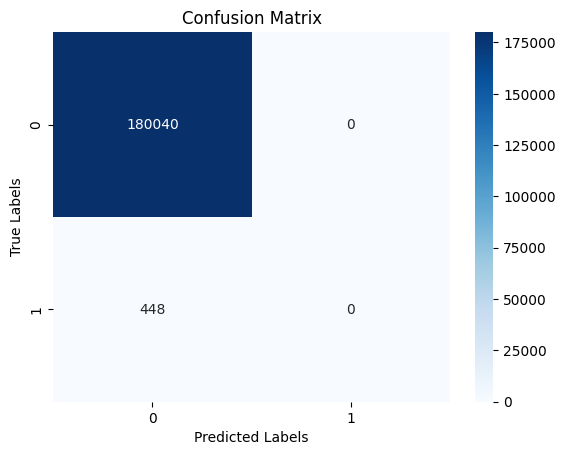

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode

    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels, b_identities = batch

            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Convert logits to class predictions
            batch_predictions = np.argmax(logits, axis=1).flatten()
            batch_labels = label_ids.flatten()

            predictions.extend(batch_predictions)
            true_labels.extend(batch_labels)

    return true_labels, predictions

# Call the evaluate function
true_labels, predictions = evaluate_model(model, validation_dataloader)

# Ensure the data types are integers for classification metrics
true_labels = np.array(true_labels).astype(int)
predictions = np.array(predictions).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Display confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()